<a href="https://colab.research.google.com/github/AaryaDesai1/XAI_Adversarial_Patch/blob/main/Adversarial_Patches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #02
### Adversarial Patches
### Aarya Desai

## Resources Used:
1. Dr. Bent's [GitHub](https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/adversarial-ai-example-notebooks/adversarial_attacks.ipynb). This is where the code is from. It has been slightly tweaked towards the end for personalized performance.
2. ChatGPT: This was used for some of the Markdowns throughout this notebook, to gain a better understanding of the code and what it's doing.

In [ ]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Duke-AI-XAI" # Change to your repo name
git_path = 'https://github.com/AIPI-590-XAI/Duke-AI-XAI.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'templates'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

#### Using environment variables in Google Colab

In Google Colab, locate the key button on the left side of the screen. You can enter in any environment variables or API keys here and they will remain private.

Then add the environment variables to your notebook using the code below.

Make sure to document in your notebook if you are using API keys and how to get them (ie share a link for documentation to get a Hugging Face API Key if you are using Hugging Face)

In [ ]:
from google.colab import userdata
userdata.get('secretName')

# Code to Create Adversarial Patches
This code was taken from Dr. Brinnae Bent's [GitHub](https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/adversarial-ai-example-notebooks/adversarial_attacks.ipynb), where she has written all the code required to download the data, create the patches, and show said patches.

For better understanding of the code, the following code chunks will be preceeded by markdowns giving some insight into what each of the cells are doing.

## Importing the necessary libraries

### Standard Libraries:
`os`, `json`, `math`, `time`, `numpy`, `scipy.linalg`: General utilities for file operations, JSON handling, math functions, time measurements, and advanced mathematical operations.

`torch`, `torch.nn`, `torch.nn.functional`, `torch.utils.data`, `torch.optim`: Core libraries for building and training neural networks.

`torchvision`: Provides image datasets and transformations.

`pytorch_lightning`: Simplifies PyTorch code for training and validation.

In [ ]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

## Setting up the Workspace:
The following code chunk first sets up the dataset and checkpoint paths, where the datasets and pretrained models will be stored.

Then it sets a random seed for reproducibility.

Lastly, it configures the GPU operations for determinism and then determines the device for computation. It also ensures that the CPU is used in case the GPU is unavailable.

In [ ]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

## Downloading and Preparing the Data:
The following code chunk handles the downloading and preparation of necessary files for the project:

1. Define the Base URL and Files: Specifies the URL where the dataset and pretrained models are hosted and lists the files to be downloaded.
2. Create Directories: Ensures that the directories for storing the dataset and checkpoint files exist, creating them if necessary.
3. Download Files: Checks if each file already exists. If not, it downloads the file from the specified URL.
4. Unzip Files: If a downloaded file is a ZIP archive, it extracts its contents to the appropriate directory.

In [ ]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

## Loading and Preparing Pretrained Model:

The following code snippet sets the environment for saving and loading model checkpoints. It then loads a ResNet-34 model pretrained on ImageNet and moves it to the specified device (CPU or GPU). The model is set to evaluation mode, and gradient calculations are turned off to optimize performance during inference.

In [ ]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

## Data Preparation and Loading:

The code defines normalization parameters for preprocessing ImageNet images, sets up a series of transformations including converting images to tensors and normalizing them. It then loads the Tiny ImageNet dataset from the specified path, creating a DataLoader to handle batch processing. Finally, it reads label names from a JSON file to interpret class labels and provides a function to get label indices from label names.

In [ ]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

## Placing Adversarial Patch:

The function place_patch randomly places a given patch onto multiple images. It selects random offsets within each image and replaces a portion of the image with the patch. The patch is applied to each channel of the image, and the modified image is returned.

In [ ]:
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

## Patch Normalization:

The code defines tensors for ImageNet normalization means and standard deviations. The function patch_forward normalizes a patch by mapping its values from the range
[−∞,∞] to the ImageNet value range using the tanh function and the defined normalization parameters.

In [ ]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

## Evaluating Adversarial Patch:

The function `eval_patch` assesses the effectiveness of an adversarial patch using a validation dataset. For each image, the patch is placed at four random locations, and the model's predictions are evaluated. It calculates the accuracy of the patch in making the model misclassify images that are not of the target class, as well as the top-5 accuracy. The function returns these metrics to gauge the patch's performance.

In [ ]:
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

## Adversarial Patch Attack:

The function `patch_attack` trains an adversarial patch to mislead a model into predicting a specific target class. It splits the dataset into training and validation sets, creates a patch parameter to optimize, and sets up the training loop with SGD. The patch is trained over a specified number of epochs to maximize the model's misclassification of images. After training, it evaluates the patch's effectiveness on a hold-out set and returns the patch and its performance metrics.

In [ ]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

## Managing Evaluation Results:

The code loads evaluation results for pretrained patches from a JSON file if it exists. It also provides a function, `save_results`, to save the results of newly trained patches to the same file format. The results are stored in a structured dictionary, where tensor values are converted to standard Python data types before saving.

In [ ]:
# Load evaluation results of the pretrained patches
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)

# If you train new patches, you can save the results via calling this function
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t
                                   for t in patch_dict[cname][psize]["results"]]
                           for psize in patch_dict[cname]}
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

## Patch Retrieval and Evaluation:

The function `get_patches` manages adversarial patches for multiple classes. It checks if a pretrained patch exists; if not, it trains a new patch and saves it. For each class and patch size, it either loads the results from a previous evaluation or computes new ones. The results and patches are stored in a dictionary for easy access.

In [ ]:
def get_patches(class_names, patch_sizes):
    result_dict = dict()

    # Loop over all classes
    for name in class_names:
        result_dict[name] = dict()
        c = label_names.index(name)

        # Choose the first patch size (or you could use any other logic)
        patch_size = patch_sizes[0]
        file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")

        # Load patch if pretrained file exists, otherwise start training
        if not os.path.isfile(file_name):
            patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
            print(f"Validation results for {name} and {patch_size}:", val_results)
            torch.save(patch, file_name)
        else:
            patch = torch.load(file_name)

        # Evaluate the patch for all patch sizes
        for size in patch_sizes:
            if name in json_results:
                results = json_results[name].get(str(size), None)
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)

            # Store results and the patch in a dict for better access
            result_dict[name][size] = {
                "results": results,
                "patch": patch
            }

    return result_dict


## Choosing my Patches:
Here, I chose the following two classes that I wanted the app to misclassify my patch as. I thought it would be really interesting to have a patch that could misclassify something as a medieval device and also, if we could put an adversarial sticker on a tech product, and it misclassifying it as an iPod no matter what it is.

Also, the sizes selected were based on the starter code provided by Dr. Bent.

In [ ]:
class_names = ['guillotine', 'iPod']
patch_sizes = [32, 48, 64]

patch_dict = get_patches(class_names, patch_sizes)

## Showing the Patch:
The following code is a slight variation from the original code as it allows you to choose one patch at a time instead of printing all of them in a grid. Here, you select the class name and the patch size and get your patch!

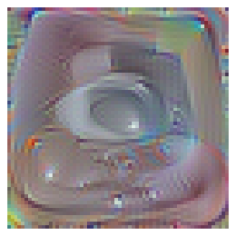

In [ ]:
def show_patch(cname, psize):
    # Check if the class name and patch size exist in the dictionary
    if cname not in patch_dict or psize not in patch_dict[cname]:
        print(f"Patch for class '{cname}' and size '{psize}' not found.")
        return

    # Get the patch
    patch = patch_dict[cname][psize]["patch"]

    # Process the patch for display
    patch = (torch.tanh(patch) + 1) / 2  # Convert to pixel values
    patch = patch.cpu().permute(1, 2, 0).numpy()
    patch = np.clip(patch, a_min=0.0, a_max=1.0)

    # Create the plot
    plt.figure(figsize=(4, 4))  # Adjust the size as needed
    plt.imshow(patch)
    plt.axis('off')  # Hide axes
    plt.show()

# Example usage: Display patch for class 'class1' and patch size 32
show_patch('iPod', 64)